In [7]:
import numpy as np

import jax
import jax.numpy as jnp

# -------------- helper libraries -------------- #
import sys
import os
import time
import pickle

import matplotlib.pyplot as plt
import pandas as pd
import importlib
import itertools

def append_path(path):
    if path not in sys.path:
        sys.path.append(path)

append_path(os.path.abspath(os.path.join('..', '00_utils')))
append_path(os.path.abspath(os.path.join('..', '00_utils_training')))
append_path(os.path.abspath(os.path.join('..', '00_models')))

import run_train_toy
importlib.reload(run_train_toy)
Trainer = run_train_toy.TrainerToy

import analyse_results
reload_module = analyse_results.reload_module

Graphs = reload_module('analyse_results', 'Graphs')
Results = reload_module('analyse_results', 'Results')
convert_lists_in_tuple = reload_module('analyse_results', 'convert_lists_in_tuple')
Trainer = reload_module('run_train_toy', 'TrainerToy')

import logging
logging.basicConfig(level=logging.ERROR, filename='error_log.txt')

In [94]:
def run(optimization_type):
  Trainer = reload_module('run_train_toy', 'TrainerToy')
  trainer = Trainer.load_trainer("vdp", spacing_type = "uniform", model_type = "jax_diffrax") 
  results = {}
  AVERAGED = False

  params_model = {
      'layer_widths': [2, 8, 2],
      'penalty_lambda_reg': 1e-3,
      'time_invariant': True,
      'learning_rate': 1e-3,
      'max_iter': [1000, 6000],
      'pretrain': [0.2, 1],
      'verbose': True,
      'rtol': 1e-3,
      'atol': 1e-6,
      "log": False,
      'act_func': 'tanh',
      'split_time': True
  }

  if optimization_type == 'network_size':
    lw = [[2, 8, 2], [2, 16, 2], [2, 32, 2], [2, 16, 16, 2], [2, 32, 32, 2]]
    lw = [[2, 8, 2], [2, 16, 2], [2, 32, 2], [2, 64, 2], [2, 128, 2]]
    reg_list = [1e-5, 1e-4, 1e-3]
    max_iter_li = [[1000, 5000], [1000, 7500], [1000, 10000]]
    param_combinations = list(itertools.product(lw, reg_list, max_iter_li))
  elif optimization_type == 'tolerance':
    rtol = [1e-1, 1e-2, 1e-3, 1e-4, 1e-5]
    atol = [1e-3, 1e-4, 1e-5, 1e-6, 1e-7]
    param_combinations = list(itertools.product(rtol, atol))
  elif optimization_type == 'none':
    param_combinations = [0]
  elif optimization_type == 'activation':
    act = ['tanh', 'relu', 'sigmoid']
    data = ['vdp', 'ho', 'do']
    param_combinations = list(itertools.product(act, data))
  elif optimization_type == 'training_convergence':
    data = ['ho', 'vdp', 'do']
    data = ['vdp']
    pretrain = [False, [0.2, 1]]
    #params_model['log'] = 50
    params_model['log'] = False 
    params_model['split_time'] = True
    param_combinations = list(itertools.product(data, pretrain))
  elif optimization_type == 'regularization':
    reg_list = [0, 1e-06, 1.0e-04, 1.0e-03, 1.0e-02, 1.0e-01,1]
    param_combinations = reg_list
  elif optimization_type == 'default':
    param_combinations = [None]
  else:
    raise ValueError("Invalid optimization type")

  total_iter = len(param_combinations)
  i = 1

  for param_comb in param_combinations:
      if optimization_type == 'network_size':
        lw = param_comb[0]
        params_model['layer_widths'] = lw
        params_model['penalty_lambda_reg'] = param_comb[1]
        params_model['max_iter'] = param_comb[2]
      
      elif optimization_type == 'regularization':
        params_model['penalty_lambda_reg'] = param_comb
        
      elif optimization_type == 'tolerance':
        params_model['rtol'] = param_comb[0]
        params_model['atol'] = param_comb[1]
        
      elif optimization_type == 'activation':
        params_model['act_func'] = param_comb[0]
        trainer = Trainer.load_trainer(param_comb[1], spacing_type = "uniform", model_type = "jax_diffrax") 
        
      elif optimization_type == 'training_convergence':
          trainer = Trainer.load_trainer(param_comb[0], spacing_type = "uniform", model_type = "jax_diffrax") 
          params_model['pretrain'] = param_comb[1]
          # params_model['log'] = True
          if params_model['pretrain'] == False:
              params_model['max_iter'] = 50000
              params_model['log'] = 250 if params_model['log'] else False
          else:
              params_model['max_iter'] = [1000, 30000]
              params_model['log'] = 100 if params_model['log'] else False
      else:
        if optimization_type != 'default':
          raise ValueError("Invalid optimization type")
        else:
          pass
      
      print(params_model['log'])
      if not AVERAGED:
        try:
          trainer.train(params_model)
        except Exception as e:
          print("Failed to complete training: {}".format(e))
          logging.error("Failed to complete training: {}".format(e))
          continue
        
        if isinstance(param_comb, tuple):
          param_comb = convert_lists_in_tuple(param_comb)
        result = trainer.extract_results()
        print(param_comb)
        
        if optimization_type == 'training_convergence':
          param_comb = (param_comb[0], True if param_comb[1] else False)
          
        results[param_comb] = result
        
        if optimization_type == 'training_convergence':
            training_loss = trainer.losses
            results[param_comb]['training_loss'] = training_loss
        
        print(results[param_comb]['mse_train'])
        print(results[param_comb]['mse_test'])
        print(results[param_comb]['time_elapsed'])
        
      if AVERAGED:
        mse_train = []
        mse_test = []
        time_elapsed = []
        for _ in range(5):
          try:
            trainer.train(params_model)
          except Exception as e:
            print("Failed to complete training: {}".format(e))
            logging.error("Failed to complete training: {}".format(e))
            continue
            
          result = trainer.extract_results()
          mse_train.append(result['mse_train'])
          mse_test.append(result['mse_test'])
          time_elapsed.append(result['time_elapsed'])
          
        results[param_comb] = {
            'mse_train': np.mean(mse_train),
            'mse_test': np.mean(mse_test),
            'time_elapsed': np.mean(time_elapsed)
        }
        
        print(results[param_comb]['mse_train'])
        print(results[param_comb]['mse_test'])
      
      print("Iteration:", i, "/", total_iter)
      i+=1
  
  if optimization_type == 'default':
    return results, trainer   
  return results

In [95]:
avg_time = 0
n = 5

for i in range(n):
    results, trainer = run('default')
    avg_time += sum(results[None]['time_elapsed'])
    
avg_time = avg_time/n

False
Epoch 100, Loss: 1.6126391435818324
Epoch 200, Loss: 0.7651540717080243
Epoch 300, Loss: 0.5733684028030543
Epoch 400, Loss: 0.522269979731206
Epoch 500, Loss: 0.48665775806430417
Epoch 600, Loss: 0.449014396014586
Epoch 700, Loss: 0.4079570757595587
Epoch 800, Loss: 0.36323380762270885
Epoch 900, Loss: 0.31492595562804565
Epoch 1000, Loss: 0.26456391395761214
Epoch 100, Loss: 2.7020522009674472
Epoch 200, Loss: 2.1078530302762046
Epoch 300, Loss: 0.726154456492914
Epoch 400, Loss: 0.6233925408359964
Epoch 500, Loss: 0.5757187838108235
Epoch 600, Loss: 0.5488643572613383
Epoch 700, Loss: 0.5327164496912806
Epoch 800, Loss: 0.5231496774957182
Epoch 900, Loss: 0.5113228773412236
Epoch 1000, Loss: 0.5050357974459005
Epoch 1100, Loss: 0.4986660571175884
Epoch 1200, Loss: 0.49079834771697345
Epoch 1300, Loss: 0.4849110699633918
Epoch 1400, Loss: 0.4797944048571545
Epoch 1500, Loss: 0.4742668784634133
Epoch 1600, Loss: 0.46964315909797044
Epoch 1700, Loss: 0.464107615199211
Epoch 1800,

In [96]:
avg_time

6.324500322341919

In [97]:
print(sum(results[None]['time_elapsed']))
results[None]

6.011193752288818


{'time_elapsed': [1.877992868423462, 4.1332008838653564],
 'mse_train': Array(0.1872842, dtype=float64),
 'mse_test': Array(1.21127511, dtype=float64)}

In [72]:
reload = False
if reload:
    formatted_time = time.strftime('%Y-%m-%d_%H-%M-%S')
    filename = f'results/jax_single_network_size.pkl'
    with open(filename, 'wb') as file:
        pickle.dump(results, file)
        
    print(f"Results saved to {filename}")

----

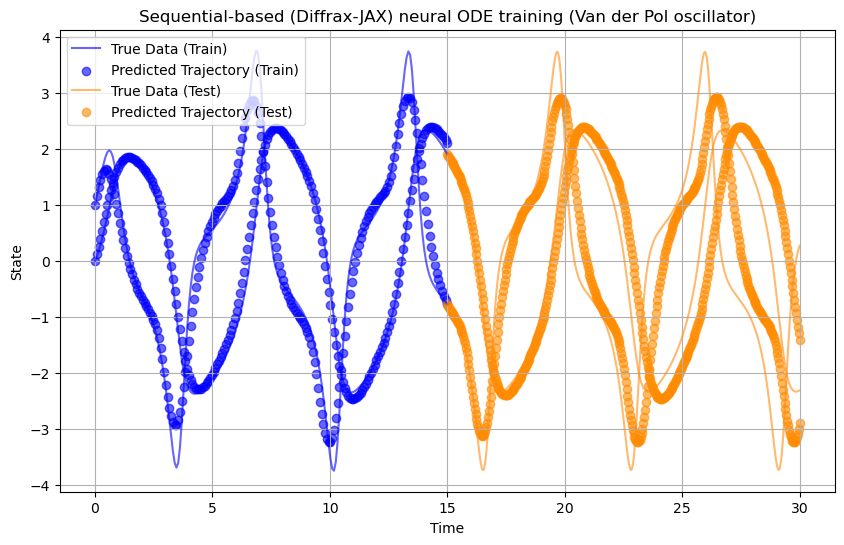

In [68]:
detailed_result = trainer.extract_results_diffrax(detailed = True)
y_pred = detailed_result['odeint_pred']
y_pred_test = detailed_result['odeint_pred_test']

plt.figure(figsize=(10, 6))

plt.plot(trainer.t, trainer.y[:,0], color = 'blue', label='True Data (Train)', alpha = 0.6)
plt.plot(trainer.t, trainer.y[:,1], color = 'blue', alpha = 0.6)
plt.scatter(trainer.t, y_pred[:,0], color = 'blue', label='Predicted Trajectory (Train)', alpha = 0.6)
plt.scatter(trainer.t, y_pred[:,1], color = 'blue', alpha = 0.6)

plt.plot(trainer.t_test, trainer.y_test[:,0], color='#FF8C10', label='True Data (Test)', alpha = 0.6)
plt.plot(trainer.t_test, trainer.y_test[:,1], color='#FF8C10', alpha = 0.6)
plt.scatter(trainer.t_test, y_pred_test[:,0], color='#FF8C00', label='Predicted Trajectory (Test)', alpha = 0.6)
plt.scatter(trainer.t_test, y_pred_test[:,1], color='#FF8C00', alpha = 0.6)

plt.title(f"Sequential-based (Diffrax-JAX) neural ODE training (Van der Pol oscillator)")
plt.xlabel("Time")
plt.ylabel("State")
plt.legend(loc ="upper left")
plt.grid(True)
plt.show()